In [17]:
import nest_asyncio
import prompts
import importlib
import state 
import nodes 
from langgraph.graph import START, END, StateGraph
from IPython.display import Image, display
from langchain_core.runnables.graph import MermaidDrawMethod
from typing import Dict, Any, Tuple, Literal
from langgraph.prebuilt import ToolNode
from langchain_core.tools import tool
from langchain_core.messages import ToolMessage
import os
from openai import OpenAI
from dotenv import load_dotenv
importlib.reload(prompts)
importlib.reload(state)
importlib.reload(nodes)
from nodes import assistant, summarize_packets, tool_list
from state import HoneypotStateReact
nest_asyncio.apply()


def display_graph(graph, width=500, height=600):

    png_bytes = graph.get_graph().draw_mermaid_png(draw_method=MermaidDrawMethod.PYPPETEER)

    display(Image(data=png_bytes, format="png", width=width, height=height)
)

def is_api_key_valid():
    try:
        client = OpenAI(api_key=os.getenv("OPENAI_API_KEY"))
        response = client.responses.create(
            model="gpt-4o",
            instructions="Test API key",
            input="Test API key",
            max_output_tokens=16
            )
    except Exception as e:
        print(f"Error: {e}")
        return False
    else:
        return True

In [18]:

# Load environment variables
load_dotenv()
os.environ["OPENAI_API_KEY"] = os.getenv("OPENAI_API_KEY")
#  Check the validity of the API key
api_key_valid = is_api_key_valid()
print("API key is valid:", api_key_valid)
print("\n" * 10)

INFO:httpx:HTTP Request: POST https://api.openai.com/v1/responses "HTTP/1.1 200 OK"


API key is valid: True













In [8]:
def should_continue(state: HoneypotStateReact) -> Literal["tools", "summarize", "__end__"]:
    """Determine next action based on the last message"""
    last_message = state.messages[-1]
    
    # If the last message has tool calls, execute them
    if hasattr(last_message, 'tool_calls') and last_message.tool_calls:
        return "tools"
    
    # Check if we need to summarize packet data
    if any(isinstance(msg, ToolMessage) and msg.name in ['get_packets', 'get_recent_packets'] 
           for msg in state.messages) and not state.packet_summary:
        return "summarize"
    
    # Otherwise, we're done
    return "__end__"

In [9]:
tool_node = ToolNode(tool_list())

In [10]:
# Build the graph
def build_react_graph():
    """Build the LangGraph workflow"""
    builder = StateGraph(HoneypotStateReact)
    
    # Add nodes
    builder.add_node("assistant", assistant)
    builder.add_node("tools", tool_node)
    builder.add_node("summarize", summarize_packets)
    
    # Add edges
    builder.add_edge(START, "assistant")
    builder.add_conditional_edges("assistant", should_continue)
    builder.add_edge("tools", "assistant")
    builder.add_edge("summarize", "assistant")
    
    return builder.compile()


INFO:pyppeteer.launcher:Browser listening on: ws://127.0.0.1:42405/devtools/browser/aad701bc-3332-4e55-aa42-f135477c0dea
INFO:pyppeteer.launcher:terminate chrome process...


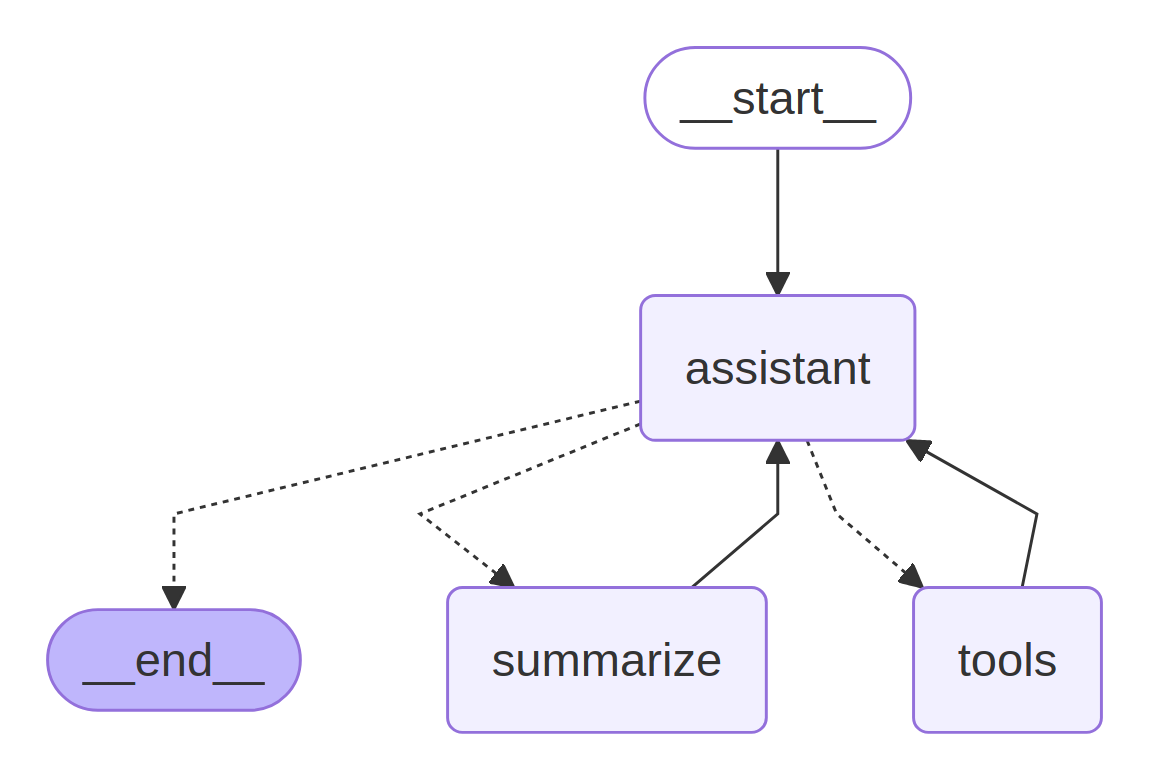

In [11]:
graph = build_react_graph()
display_graph(graph)

In [13]:
# Create an initial state
initial_state = HoneypotStateReact(
    messages=[],
    packet_summary="",
    tools_complete=False
)

response = graph.invoke(initial_state)

INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
INFO:tools:Retrieving firewall rules...
INFO:tools:Retrieving packet statistics...
INFO:tools:Successfully retrieved firewall rules
INFO:tools:Successfully retrieved packet stats
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 400 Bad Request"


BadRequestError: Error code: 400 - {'error': {'message': "Invalid parameter: messages with role 'tool' must be a response to a preceeding message with 'tool_calls'.", 'type': 'invalid_request_error', 'param': 'messages.[1].role', 'code': None}}

In [ ]:
for m in response['messages']:
    m.pretty_print()

================================== Ai Message ==================================
Tool Calls:
  getNetworkStatus (call_r3qYtmvzbDGDN8gryPzuP3JL)
 Call ID: call_r3qYtmvzbDGDN8gryPzuP3JL
  Args:
    file_path: /home/c0ff3k1ll3r/Desktop/Thesis/AI_Agent_for_honeypot_operations/logsSSH/tshark_pcap/ssh_traffic.json
  getFirewallConfiguration (call_6hdcQZ1YDdo99RCZ528Jr34Z)
 Call ID: call_6hdcQZ1YDdo99RCZ528Jr34Z
  Args:
  getDockerContainers (call_YjFCh2yp0ZkXOjrBp8HxF8O5)
 Call ID: call_YjFCh2yp0ZkXOjrBp8HxF8O5
  Args:
================================== Ai Message ==================================
Tool Calls:
  getFirewallConfiguration (call_IZGSv0wwM7aOS71ps0nMhQTZ)
 Call ID: call_IZGSv0wwM7aOS71ps0nMhQTZ
  Args:
  getDockerContainers (call_wFbjhgdu9sNpofBoeeOqqFUa)
 Call ID: call_wFbjhgdu9sNpofBoeeOqqFUa
  Args:
================================== Ai Message ==================================
Tool Calls:
  getNetworkStatus (call_TMsDFrsT1cIWRo1lryyaelUG)
 Call ID: call_TMsDFrsT1cIWRo1lryya